### IMPORTS 

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import tensorflow as tf

%matplotlib inline

from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import io
import requests
import shutil
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers
from sklearn import metrics

### HELPER FUNCTION

In [14]:

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)
    
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

    # Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
    import numpy as np

def to_sequences(seq_size, data1, data2):
    x = []
    y = []

    for i in range(len(data1)-seq_size):
        #print(i)
        window = data1[i:(i+seq_size)]
        after_window = data2[i+seq_size]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x), np.array(y)

### LOAD THE DATA CSV  FILE

In [15]:
path = "/Users/pavan/Desktop/ai 2nd pro"
csvfile = os.path.join(path,"CSC215_P2_Stock_Price.csv") 
df_stock = pd.read_csv(csvfile)

#print first and last 5 rows in new csv file
print(df_stock.head())
print(df_stock.tail())

print("\nNumber of columns and row currently:")
print("Data: ", df_stock.shape)

        Date      Open      High       Low     Close  Adj_Close   Volume
0  2000/3/27  3.812500  4.156250  3.812500  4.125000   4.125000  3675600
1  2000/3/28  4.125000  4.125000  4.000000  4.015625   4.015625  1077600
2  2000/3/29  4.000000  4.031250  3.953125  4.000000   4.000000   437200
3  2000/3/30  4.000000  4.000000  3.843750  3.843750   3.843750  1883600
4  2000/3/31  3.734375  3.734375  3.390625  3.390625   3.390625  7931600
          Date        Open        High         Low       Close   Adj_Close  \
4387  2017/9/1  113.790001  114.099998  112.790001  113.309998  113.309998   
4388  2017/9/5  112.519997  113.529999  111.160004  111.870003  111.870003   
4389  2017/9/6  112.029999  112.489998  110.250000  112.230003  112.230003   
4390  2017/9/7  112.459999  112.900002  112.000000  112.339996  112.339996   
4391  2017/9/8  112.300003  114.790001  112.010002  113.190002  113.190002   

       Volume  
4387   950000  
4388  1805200  
4389  2136700  
4390  1251600  
4391  1611700

#### Drop missing values and columns 

In [16]:
# Storing in a different dataframe before dropping the columns
df_newstock= df_stock

# Drop rows if there are any missing values
df_newstock.isnull().all(axis=1)
df_newstock = df_newstock.dropna()

# Dropping the columns Date and Adj_Close as mentioned
df_newstock=df_newstock.drop(['Date', 'Adj_Close'], axis=1)

#print first 5 rows in new csv file
print(df_newstock.head())

print("\nNumber of col/row currently:")
print("Data: ", df_newstock.shape)

#data about count of NaN in each column
print("\ncount of NaN in each column")
print(df_newstock.isnull().sum())

       Open      High       Low     Close   Volume
0  3.812500  4.156250  3.812500  4.125000  3675600
1  4.125000  4.125000  4.000000  4.015625  1077600
2  4.000000  4.031250  3.953125  4.000000   437200
3  4.000000  4.000000  3.843750  3.843750  1883600
4  3.734375  3.734375  3.390625  3.390625  7931600

Number of col/row currently:
Data:  (4392, 5)

count of NaN in each column
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [17]:
# creating a copy of the column, Close
df_newstock['y'] = df_newstock['Close']
#print first 5 rows in new csv file
print(df_newstock.head())

print("\nNumber of col/row currently:")
print("Data: ", df_newstock.shape)

       Open      High       Low     Close   Volume         y
0  3.812500  4.156250  3.812500  4.125000  3675600  4.125000
1  4.125000  4.125000  4.000000  4.015625  1077600  4.015625
2  4.000000  4.031250  3.953125  4.000000   437200  4.000000
3  4.000000  4.000000  3.843750  3.843750  1883600  3.843750
4  3.734375  3.734375  3.390625  3.390625  7931600  3.390625

Number of col/row currently:
Data:  (4392, 6)


### NORMALIZE NUMERICAL FEATURES

In [18]:
#Normalizing except  last column y
for column in df_newstock.columns:
  if  column != 'y':
    encode_numeric_zscore(df_newstock, column)

#print first  5 rows in new csv file to check for normalizing
print(df_newstock.head())

       Open      High       Low     Close    Volume         y
0 -0.894209 -0.885022 -0.892306 -0.884364  1.104812  4.125000
1 -0.883762 -0.886056 -0.885975 -0.888021 -0.497301  4.015625
2 -0.887941 -0.889159 -0.887558 -0.888543 -0.892217  4.000000
3 -0.887941 -0.890194 -0.891251 -0.893768 -0.000263  3.843750
4 -0.896820 -0.898986 -0.906551 -0.908920  3.729366  3.390625


In [19]:
# Set all column other than y as input or 'x'
x = df_newstock.iloc[:,df_newstock.columns != 'y']
x = np.array(x, dtype=np.float32)

# Set the y column as output or 'y'
y = np.array(df_newstock['y'].values, dtype=np.float32)
print(x.shape)
print(y.shape)

(4392, 5)
(4392,)


# DATA TRANSFORMATION

In [20]:
SEQUENCE_SIZE = 7
#x_lstm_seq_test,y_lstm_seq_test = to_sequences(SEQUENCE_SIZE,X_test,y_test)
x_lstseq, y_lstseq = to_sequences(SEQUENCE_SIZE, x, y)

#print("Shape of x_test: {}".format(x_lstm_seq_test.shape))
print("Shape of x_lstseq: {}".format(x_lstseq.shape))
#print("Shape of y_test: {}".format(y_lstm_seq_test.shape))
print("Shape of y_lstseq: {}".format(y_lstseq.shape))

#reshaping the array
x_newseq=x_lstseq.reshape(4385,35)

Shape of x_lstseq: (4385, 7, 1, 5)
Shape of y_lstseq: (4385,)


## Split train and test data 70/30

In [21]:
##Split train and test date 70/30
x_train, x_test, y_train, y_test = train_test_split(x_newseq, y_lstseq, test_size=0.3, random_state=0)

print("Shape of x_train :{}".format(x_train.shape))
print("Shape of x_test  :{}".format(x_test.shape))

print("Shape of y_train :{}".format(y_train.shape))
print("Shape of y_test  :{}".format(y_test.shape))

type(x_test),type(y_test),type(x_train),type(y_train)


Shape of x_train :(3069, 35)
Shape of x_test  :(1316, 35)
Shape of y_train :(3069,)
Shape of y_test  :(1316,)


(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

###  NEURAL NETWORKS

Optimizer  used:  adam  Activation Function used :  relu
Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 1s - loss: 1052.0690 - val_loss: 180.2084
Epoch 2/200
3069/3069 - 0s - loss: 157.1197 - val_loss: 140.3320
Epoch 3/200
3069/3069 - 0s - loss: 118.2251 - val_loss: 101.0385
Epoch 4/200
3069/3069 - 0s - loss: 79.5448 - val_loss: 66.1240
Epoch 5/200
3069/3069 - 0s - loss: 49.1995 - val_loss: 37.4600
Epoch 6/200
3069/3069 - 0s - loss: 23.5364 - val_loss: 16.4707
Epoch 7/200
3069/3069 - 0s - loss: 9.7188 - val_loss: 8.0399
Epoch 8/200
3069/3069 - 0s - loss: 4.5952 - val_loss: 4.9756
Epoch 9/200
3069/3069 - 0s - loss: 2.8534 - val_loss: 3.8274
Epoch 10/200
3069/3069 - 0s - loss: 2.1639 - val_loss: 3.2563
Epoch 11/200
3069/3069 - 0s - loss: 1.7240 - val_loss: 2.7823
Epoch 12/200
3069/3069 - 0s - loss: 1.5299 - val_loss: 2.5667
Epoch 13/200
3069/3069 - 0s - loss: 1.4279 - val_loss: 2.3323
Epoch 14/200
3069/3069 - 0s - loss: 1.2614 - val_loss: 2.3768
Epoch 15/200
3069

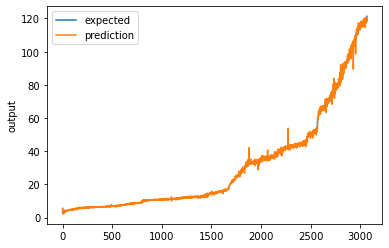

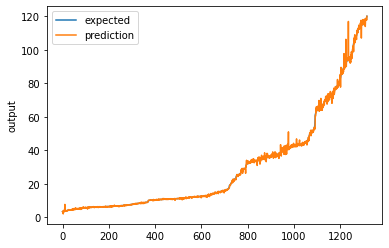

Optimizer  used:  adam  Activation Function used :  sigmoid
Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 1s - loss: 1651.8648 - val_loss: 1518.3726
Epoch 2/200
3069/3069 - 0s - loss: 1492.5617 - val_loss: 1412.3725
Epoch 3/200
3069/3069 - 0s - loss: 1391.9183 - val_loss: 1316.7649
Epoch 4/200
3069/3069 - 0s - loss: 1300.1828 - val_loss: 1228.6329
Epoch 5/200
3069/3069 - 0s - loss: 1203.6975 - val_loss: 1129.8060
Epoch 6/200
3069/3069 - 0s - loss: 1111.3657 - val_loss: 1045.7894
Epoch 7/200
3069/3069 - 0s - loss: 1032.2813 - val_loss: 972.4750
Epoch 8/200
3069/3069 - 0s - loss: 961.2791 - val_loss: 904.8467
Epoch 9/200
3069/3069 - 0s - loss: 896.0254 - val_loss: 842.8534
Epoch 10/200
3069/3069 - 0s - loss: 836.2020 - val_loss: 786.5605
Epoch 11/200
3069/3069 - 0s - loss: 781.4782 - val_loss: 734.6782
Epoch 12/200
3069/3069 - 0s - loss: 731.4473 - val_loss: 687.9517
Epoch 13/200
3069/3069 - 0s - loss: 686.0243 - val_loss: 645.4489
Epoch 14/200
3069/3069 - 0s - 

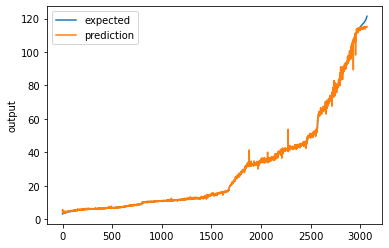

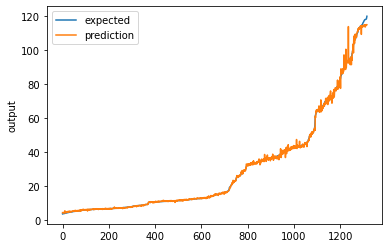

Optimizer  used:  adam  Activation Function used :  tanh
Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 2s - loss: 1645.5293 - val_loss: 1492.8416
Epoch 2/200
3069/3069 - 0s - loss: 1347.5205 - val_loss: 1174.1568
Epoch 3/200
3069/3069 - 0s - loss: 1122.8247 - val_loss: 1030.8168
Epoch 4/200
3069/3069 - 0s - loss: 999.7159 - val_loss: 924.8209
Epoch 5/200
3069/3069 - 0s - loss: 902.2103 - val_loss: 836.3949
Epoch 6/200
3069/3069 - 0s - loss: 819.4289 - val_loss: 759.8556
Epoch 7/200
3069/3069 - 0s - loss: 745.9826 - val_loss: 692.5097
Epoch 8/200
3069/3069 - 0s - loss: 681.4941 - val_loss: 631.7712
Epoch 9/200
3069/3069 - 0s - loss: 624.6794 - val_loss: 580.2772
Epoch 10/200
3069/3069 - 0s - loss: 575.1966 - val_loss: 534.0141
Epoch 11/200
3069/3069 - 0s - loss: 531.6505 - val_loss: 493.9659
Epoch 12/200
3069/3069 - 0s - loss: 493.5774 - val_loss: 458.6274
Epoch 13/200
3069/3069 - 0s - loss: 459.9080 - val_loss: 427.4688
Epoch 14/200
3069/3069 - 0s - loss: 428.

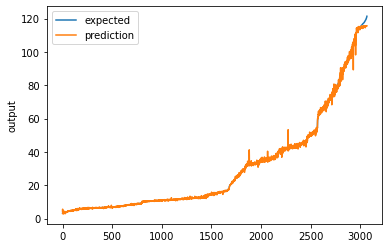

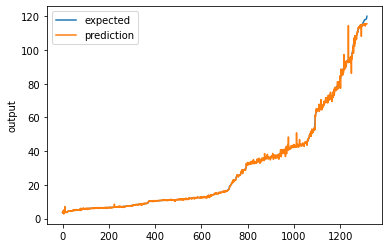

Optimizer  used:  sgd  Activation Function used :  relu
Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 1s - loss: nan - val_loss: nan
Epoch 2/200
3069/3069 - 0s - loss: nan - val_loss: nan
Epoch 3/200
3069/3069 - 0s - loss: nan - val_loss: nan
Epoch 4/200
3069/3069 - 0s - loss: nan - val_loss: nan
Epoch 5/200
3069/3069 - 0s - loss: nan - val_loss: nan
Epoch 00005: early stopping
Score_train (RMSE): 52.05027770996094
Score_test (RMSE): 51.603729248046875


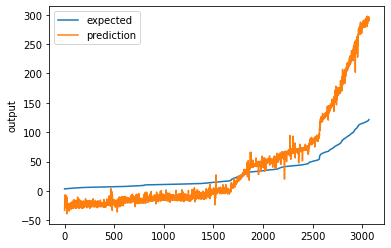

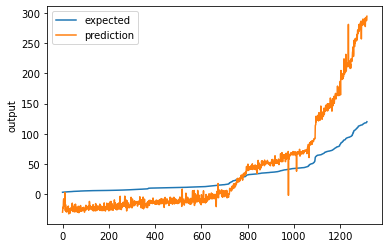

Optimizer  used:  sgd  Activation Function used :  sigmoid
Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 1s - loss: 173.4757 - val_loss: 26.7901
Epoch 2/200
3069/3069 - 0s - loss: 70.7555 - val_loss: 66.2053
Epoch 3/200
3069/3069 - 0s - loss: 59.9758 - val_loss: 91.1449
Epoch 4/200
3069/3069 - 0s - loss: 52.9956 - val_loss: 40.6960
Epoch 5/200
3069/3069 - 0s - loss: 35.6872 - val_loss: 30.7625
Epoch 6/200
3069/3069 - 0s - loss: 31.8051 - val_loss: 16.7416
Epoch 7/200
3069/3069 - 0s - loss: 35.9475 - val_loss: 21.3016
Epoch 8/200
3069/3069 - 0s - loss: 31.5086 - val_loss: 24.3395
Epoch 9/200
3069/3069 - 0s - loss: 23.0126 - val_loss: 23.5359
Epoch 10/200
3069/3069 - 0s - loss: 13.7525 - val_loss: 5.9138
Epoch 11/200
3069/3069 - 0s - loss: 21.3855 - val_loss: 34.8491
Epoch 12/200
3069/3069 - 0s - loss: 14.4557 - val_loss: 5.7869
Epoch 13/200
3069/3069 - 0s - loss: 23.2899 - val_loss: 6.8301
Epoch 14/200
3069/3069 - 0s - loss: 10.5527 - val_loss: 3.9477
Epoch 15/

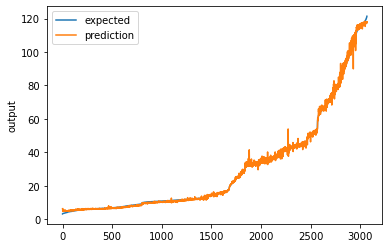

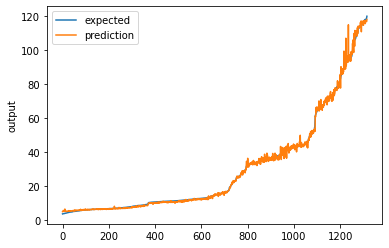

Optimizer  used:  sgd  Activation Function used :  tanh
Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 2s - loss: 576.5627 - val_loss: 165.5099
Epoch 2/200
3069/3069 - 0s - loss: 149.0813 - val_loss: 344.7594
Epoch 3/200
3069/3069 - 0s - loss: 154.2437 - val_loss: 215.2187
Epoch 4/200
3069/3069 - 0s - loss: 188.2220 - val_loss: 226.3409
Epoch 5/200
3069/3069 - 0s - loss: 194.9545 - val_loss: 91.8826
Epoch 6/200
3069/3069 - 0s - loss: 96.8598 - val_loss: 58.3047
Epoch 7/200
3069/3069 - 0s - loss: 156.6480 - val_loss: 137.1687
Epoch 8/200
3069/3069 - 0s - loss: 250.5548 - val_loss: 275.2536
Epoch 9/200
3069/3069 - 0s - loss: 214.1288 - val_loss: 198.4094
Epoch 10/200
3069/3069 - 0s - loss: 174.8809 - val_loss: 199.8065
Epoch 11/200
3069/3069 - 0s - loss: 231.6090 - val_loss: 296.2096
Epoch 00011: early stopping
Score_train (RMSE): 7.902224063873291
Score_test (RMSE): 7.635753631591797


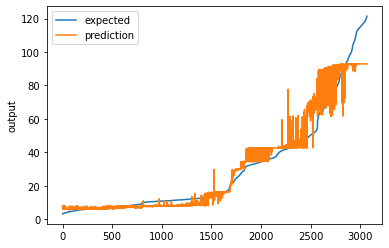

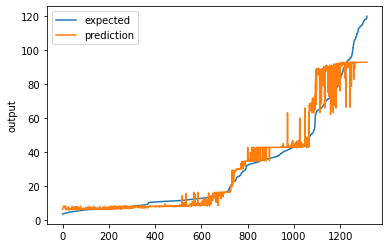

In [22]:
# List of posible activation functions
activation_functions = ['relu','sigmoid','tanh']
# List of posible optimizers
optimizers = ['adam','sgd']

# Loop through all combination of optimizers and activation functions
for optimizer in optimizers:
  for activ_function in activation_functions:
    print("Optimizer  used: ", optimizer, " Activation Function used : ", activ_function)

    model = Sequential()
    model.add(Dense(64, input_dim=x_train.shape[1], activation=activ_function))
    model.add(Dense(32,activation=activ_function))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    checkpointer = ModelCheckpoint(filepath="best_weights_NN.hdf5", verbose=0, save_best_only=True)

    model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=200)

    model.load_weights('best_weights_NN.hdf5')  


    pred_train = model.predict(x_train)
    score_train = np.sqrt(metrics.mean_squared_error(pred_train,y_train))
    print("Score_train (RMSE): {}".format(score_train))

    pred_test = model.predict(x_test)
    score_test = np.sqrt(metrics.mean_squared_error(pred_test,y_test))
    print("Score_test (RMSE): {}".format(score_test))

    
    #chart_regression(pred.flatten(),y_lstseqtest, sort=True)
    chart_regression(pred_train.flatten(),y_train, sort=True)
    chart_regression(pred_test.flatten(),y_test, sort=True) 

Optimizer  used:  adam  Activation Function used :  relu
Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 2s - loss: 819.7254 - val_loss: 152.8334
Epoch 2/200
3069/3069 - 0s - loss: 129.3459 - val_loss: 102.9445
Epoch 3/200
3069/3069 - 0s - loss: 75.1239 - val_loss: 50.3458
Epoch 4/200
3069/3069 - 0s - loss: 30.3120 - val_loss: 18.8877
Epoch 5/200
3069/3069 - 0s - loss: 10.3058 - val_loss: 9.6142
Epoch 6/200
3069/3069 - 0s - loss: 4.8785 - val_loss: 6.6628
Epoch 7/200
3069/3069 - 0s - loss: 3.0319 - val_loss: 4.1068
Epoch 8/200
3069/3069 - 0s - loss: 2.0890 - val_loss: 3.7225
Epoch 9/200
3069/3069 - 0s - loss: 1.7834 - val_loss: 3.0078
Epoch 10/200
3069/3069 - 0s - loss: 1.5722 - val_loss: 3.1629
Epoch 11/200
3069/3069 - 0s - loss: 1.4977 - val_loss: 2.4358
Epoch 12/200
3069/3069 - 0s - loss: 1.3378 - val_loss: 2.5132
Epoch 13/200
3069/3069 - 0s - loss: 1.4207 - val_loss: 3.9752
Epoch 14/200
3069/3069 - 0s - loss: 1.3258 - val_loss: 2.2694
Epoch 15/200
3069/3069 

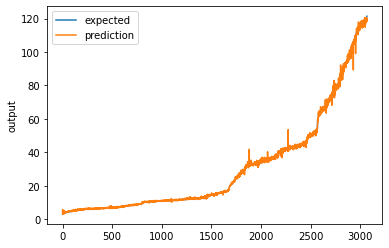

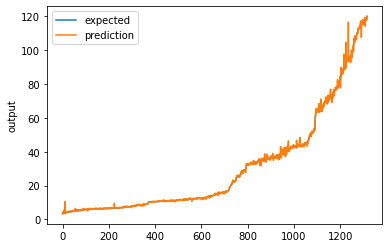

Optimizer  used:  adam  Activation Function used :  sigmoid
Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 2s - loss: 1742.9790 - val_loss: 1599.0764
Epoch 2/200
3069/3069 - 0s - loss: 1562.6566 - val_loss: 1472.7770
Epoch 3/200
3069/3069 - 0s - loss: 1454.3329 - val_loss: 1381.2577
Epoch 4/200
3069/3069 - 0s - loss: 1370.6066 - val_loss: 1306.2291
Epoch 5/200
3069/3069 - 0s - loss: 1297.3209 - val_loss: 1233.9574
Epoch 6/200
3069/3069 - 0s - loss: 1227.1475 - val_loss: 1172.1369
Epoch 7/200
3069/3069 - 0s - loss: 1169.1156 - val_loss: 1119.5226
Epoch 8/200
3069/3069 - 0s - loss: 1111.1723 - val_loss: 1050.3198
Epoch 9/200
3069/3069 - 0s - loss: 1037.1777 - val_loss: 979.1746
Epoch 10/200
3069/3069 - 0s - loss: 971.3060 - val_loss: 918.4481
Epoch 11/200
3069/3069 - 0s - loss: 912.4551 - val_loss: 863.1299
Epoch 12/200
3069/3069 - 0s - loss: 859.0658 - val_loss: 811.5433
Epoch 13/200
3069/3069 - 0s - loss: 810.0308 - val_loss: 765.6403
Epoch 14/200
3069/3069 - 0

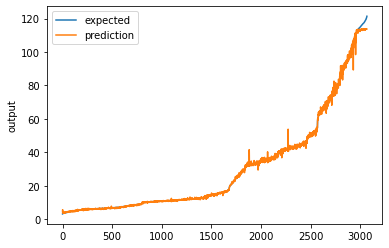

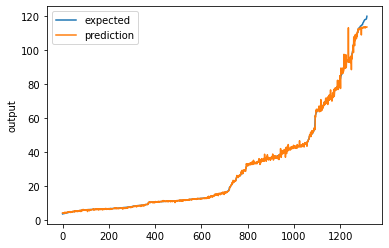

Optimizer  used:  adam  Activation Function used :  tanh
Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 2s - loss: 1597.5071 - val_loss: 1327.7541
Epoch 2/200
3069/3069 - 0s - loss: 1236.6253 - val_loss: 1128.8539
Epoch 3/200
3069/3069 - 0s - loss: 1093.3511 - val_loss: 1013.0191
Epoch 4/200
3069/3069 - 0s - loss: 986.7853 - val_loss: 914.4013
Epoch 5/200
3069/3069 - 0s - loss: 893.4267 - val_loss: 827.9211
Epoch 6/200
3069/3069 - 0s - loss: 811.4849 - val_loss: 753.1646
Epoch 7/200
3069/3069 - 0s - loss: 739.9929 - val_loss: 686.6334
Epoch 8/200
3069/3069 - 0s - loss: 677.1004 - val_loss: 628.2173
Epoch 9/200
3069/3069 - 0s - loss: 621.6518 - val_loss: 577.0810
Epoch 10/200
3069/3069 - 0s - loss: 572.8651 - val_loss: 531.7730
Epoch 11/200
3069/3069 - 0s - loss: 529.8303 - val_loss: 492.0948
Epoch 12/200
3069/3069 - 0s - loss: 491.9474 - val_loss: 457.6055
Epoch 13/200
3069/3069 - 0s - loss: 458.0258 - val_loss: 424.7962
Epoch 14/200
3069/3069 - 0s - loss: 424.

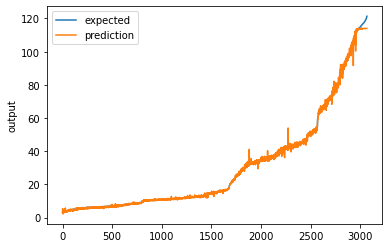

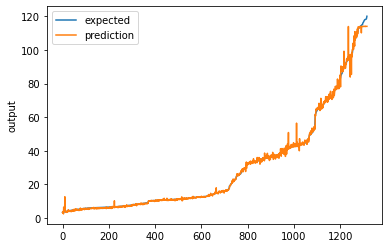

Optimizer  used:  sgd  Activation Function used :  relu
Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 1s - loss: nan - val_loss: nan
Epoch 2/200
3069/3069 - 0s - loss: nan - val_loss: nan
Epoch 3/200
3069/3069 - 0s - loss: nan - val_loss: nan
Epoch 4/200
3069/3069 - 0s - loss: nan - val_loss: nan
Epoch 5/200
3069/3069 - 0s - loss: nan - val_loss: nan
Epoch 00005: early stopping
Score_train (RMSE): 66.0793228149414
Score_test (RMSE): 65.26177978515625


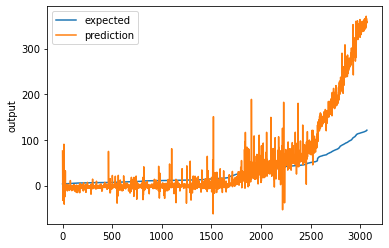

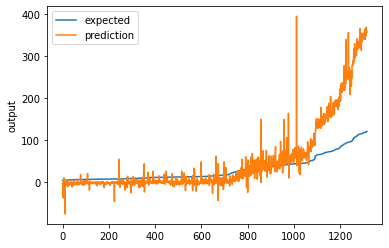

Optimizer  used:  sgd  Activation Function used :  sigmoid
Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 2s - loss: 261.4501 - val_loss: 23.9644
Epoch 2/200
3069/3069 - 0s - loss: 75.7757 - val_loss: 44.2595
Epoch 3/200
3069/3069 - 0s - loss: 89.9523 - val_loss: 53.1390
Epoch 4/200
3069/3069 - 0s - loss: 69.3985 - val_loss: 27.8478
Epoch 5/200
3069/3069 - 0s - loss: 52.1948 - val_loss: 48.6892
Epoch 6/200
3069/3069 - 0s - loss: 36.7337 - val_loss: 10.2442
Epoch 7/200
3069/3069 - 0s - loss: 27.4999 - val_loss: 14.7561
Epoch 8/200
3069/3069 - 0s - loss: 22.3574 - val_loss: 50.5353
Epoch 9/200
3069/3069 - 0s - loss: 17.7474 - val_loss: 22.7073
Epoch 10/200
3069/3069 - 0s - loss: 19.6764 - val_loss: 5.4850
Epoch 11/200
3069/3069 - 0s - loss: 9.2383 - val_loss: 13.4507
Epoch 12/200
3069/3069 - 0s - loss: 15.5410 - val_loss: 7.5635
Epoch 13/200
3069/3069 - 0s - loss: 7.3906 - val_loss: 3.5294
Epoch 14/200
3069/3069 - 0s - loss: 8.4859 - val_loss: 2.6394
Epoch 15/200

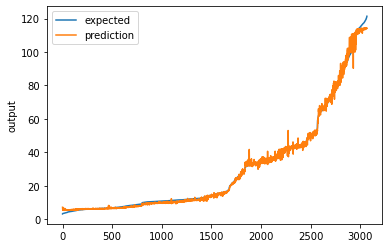

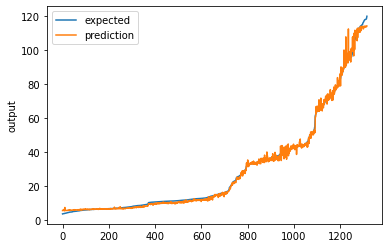

Optimizer  used:  sgd  Activation Function used :  tanh
Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 2s - loss: 585.0974 - val_loss: 140.9766
Epoch 2/200
3069/3069 - 0s - loss: 290.5467 - val_loss: 241.5093
Epoch 3/200
3069/3069 - 0s - loss: 162.7961 - val_loss: 163.1945
Epoch 4/200
3069/3069 - 0s - loss: 185.9927 - val_loss: 55.2993
Epoch 5/200
3069/3069 - 0s - loss: 174.9679 - val_loss: 302.7649
Epoch 6/200
3069/3069 - 0s - loss: 273.7666 - val_loss: 273.6138
Epoch 7/200
3069/3069 - 0s - loss: 209.3024 - val_loss: 119.4016
Epoch 8/200
3069/3069 - 0s - loss: 235.4069 - val_loss: 220.5626
Epoch 9/200
3069/3069 - 0s - loss: 276.5771 - val_loss: 307.3184
Epoch 00009: early stopping
Score_train (RMSE): 7.525050640106201
Score_test (RMSE): 7.436349391937256


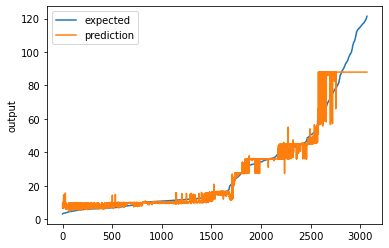

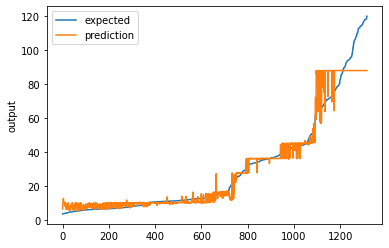

In [23]:
# List of posible activation functions
activation_functions = ['relu','sigmoid','tanh']
# List of posible optimizers
optimizers = ['adam','sgd']

# Loop through all combination of optimizers and activation functions
for optimizer in optimizers:
  for activ_function in activation_functions:
    print("Optimizer  used: ", optimizer, " Activation Function used : ", activ_function)

    model = Sequential()
    model.add(Dense(64, input_dim=x_train.shape[1], activation=activ_function))
    model.add(Dense(32,activation=activ_function))
    model.add(Dense(32,activation=activ_function))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    checkpointer = ModelCheckpoint(filepath="best_weights_NN.hdf5", verbose=0, save_best_only=True)

    model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=200)

    model.load_weights('best_weights_NN.hdf5')  


    pred_train = model.predict(x_train)
    score_train = np.sqrt(metrics.mean_squared_error(pred_train,y_train))
    print("Score_train (RMSE): {}".format(score_train))

    pred_test = model.predict(x_test)
    score_test = np.sqrt(metrics.mean_squared_error(pred_test,y_test))
    print("Score_test (RMSE): {}".format(score_test))

    
    #chart_regression(pred.flatten(),y_lstseqtest, sort=True)
    chart_regression(pred_train.flatten(),y_train, sort=True)
    chart_regression(pred_test.flatten(),y_test, sort=True) 